In [1]:
import os
import numpy as np
import pandas as pd
import progressbar
import seaborn as sns
import matplotlib.pyplot as pp
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve, classification_report, roc_curve, auc, average_precision_score, accuracy_score
pd.options.mode.chained_assignment = None

In [2]:
data_dir = os.path.join('..','data-wrangling','data','flight_data')
misc_data_dir = os.path.join('..','data-wrangling','data','misc')
feat = pd.read_csv(os.path.join(data_dir,'feat_2018.csv'), low_memory=False)
airport = pd.read_csv(os.path.join(misc_data_dir,'airport.csv'), usecols = [0, 1, 2, 3, 4, 5, 6, 11, 16, 17])
feat.head()

,month,weekDay,dayofMonth,dayofYear,hour,iata,tailNum,orgAirport,destAirport,temp,...,MemorialDay,IndependenceDay,LaborDay,ColumbusDay,VeteransDay,Thanksgiving,ChristmasDay,NxtNewYearsDay,prevArrDel,timeDiff
0,1,1,1,1,6,HA,N490HA,13830,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-5.0,-28.0
1,1,1,1,1,6,HA,N491HA,12758,12173,73.9,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-6.0,-42.0
2,1,1,1,1,6,OO,N693BR,14747,14057,34.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-3.0,-44.0
3,1,1,1,1,6,HA,N483HA,12402,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-3.0,-47.0
4,1,1,1,1,6,HA,N475HA,12982,12173,72.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-9.0,-26.0


In [3]:
grouped = feat.groupby(['orgAirport', 'destAirport'])
idx = grouped.size().sort_values(ascending=False).iloc[:20].index.values
mask = pd.Series(np.zeros(feat.shape[0]), dtype='boolean')
for i in list(idx):
    mask = mask | (feat.orgAirport == i[0]) & (feat.destAirport == i[1])
data = feat[mask]
data.head()

,month,weekDay,dayofMonth,dayofYear,hour,iata,tailNum,orgAirport,destAirport,temp,...,MemorialDay,IndependenceDay,LaborDay,ColumbusDay,VeteransDay,Thanksgiving,ChristmasDay,NxtNewYearsDay,prevArrDel,timeDiff
0,1,1,1,1,6,HA,N490HA,13830,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-5.0,-28.0
14,1,1,1,1,7,HA,N485HA,13830,12173,71.1,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-9.0,-39.0
36,1,1,1,1,7,WN,N738CB,12892,14771,57.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,7.0,-78.0
52,1,1,1,1,7,YX,N730YX,13930,12953,-4.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,2.0,-184.0
61,1,1,1,1,7,WN,N710SW,12889,12892,46.0,...,147.0,184.0,245.0,280.0,314.0,325.0,358.0,365.0,-4.0,-63.0


In [4]:
data.drop(labels=['tailNum', 'dayofYear'], axis=1, inplace=True)
data.loc[:, 'ColumbusDay'] = data.ColumbusDay.astype('float64')
data.reset_index(drop=True, inplace=True)

In [5]:
d = dict(zip(np.array(data.groupby('iata')['delayed'].sum().sort_values(ascending=False).index), [*range(13, 0, -1)] ))
data.loc[:, 'iata'] = data.loc[:, 'iata'].map(d)

In [6]:
grouped = data.groupby(['orgAirport', 'destAirport'])
keys = grouped.groups.keys()
ros = RandomOverSampler(random_state=14)
clf_rf = RandomForestClassifier(random_state=14, max_depth=8, min_samples_split=10, n_estimators=150, 
                                oob_score=False, max_samples=None, max_features='sqrt', criterion='gini', 
                                min_samples_leaf=3)
f1 = make_scorer(f1_score , average='weighted')
index = pd.MultiIndex.from_tuples(keys, names=['orgAirport', 'destAirport'])
results = pd.DataFrame({'train_size': np.empty(len(keys)), 'test_size': np.empty(len(keys)), 
                        'precision': np.empty(len(keys)), 'recall': np.empty(len(keys)), 
                        'f1_score': np.empty(len(keys)), 'auc': np.empty(len(keys)), 
                        'train_accuracy': np.empty(len(keys)), 'test_accuracy': np.empty(len(keys)), 
                        'ap': np.empty(len(keys))}, 
                       index=index)
report = []
bar = progressbar.ProgressBar(max_value=len(keys))

for i, key in enumerate(keys):
    df = grouped.get_group(key)
    X = df.drop(labels=['orgAirport', 'destAirport', 'delayed'], axis=1)
    y = df.delayed.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, shuffle=True, random_state=14)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    clf_rf.fit(X_resampled, y_resampled)
    y_pred = clf_rf.predict(X_test)
    report.append(classification_report(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, clf_rf.predict_proba(X_test)[:, 1])
    results.loc[key, 'train_size'] = X_resampled.shape[0]
    results.loc[key, 'test_size'] = X_test.shape[0]
    results.loc[key, 'precision'] = precision_score(y_test, y_pred)
    results.loc[key, 'recall'] = recall_score(y_test, y_pred)
    results.loc[key, 'f1_score'] = f1_score(y_test, y_pred)
    results.loc[key, 'auc'] = auc(fpr, tpr)
    results.loc[key, 'ap'] = average_precision_score(y_test, clf_rf.predict_proba(X_test)[:, 1])
    results.loc[key, 'train_accuracy'] = accuracy_score(y_resampled, clf_rf.predict(X_resampled))
    results.loc[key, 'test_accuracy'] = accuracy_score(y_test, clf_rf.predict(X_test))
    bar.update(i+1)

100% (20 of 20) |########################| Elapsed Time: 0:00:32 ETA:  00:00:00

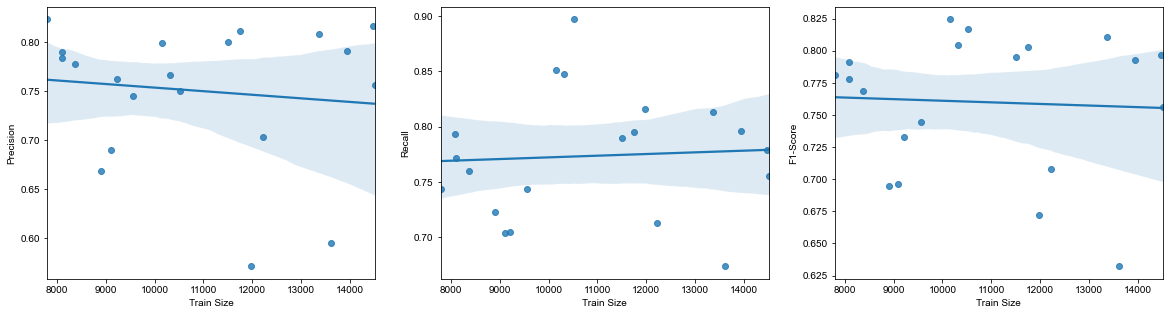

In [7]:
fig, axes = pp.subplots(figsize=(20, 5), nrows=1, ncols=3)
sns.set()
sns.regplot(x='train_size', y='precision', data=results, ax=axes[0])
axes[0].set_xlabel('Train Size')
axes[0].set_ylabel('Precision')
sns.regplot(x='train_size', y='recall', data=results, ax=axes[1])
axes[1].set_xlabel('Train Size')
axes[1].set_ylabel('Recall')
sns.regplot(x='train_size', y='f1_score', data=results, ax=axes[2])
axes[2].set_xlabel('Train Size')
axes[2].set_ylabel('F1-Score');

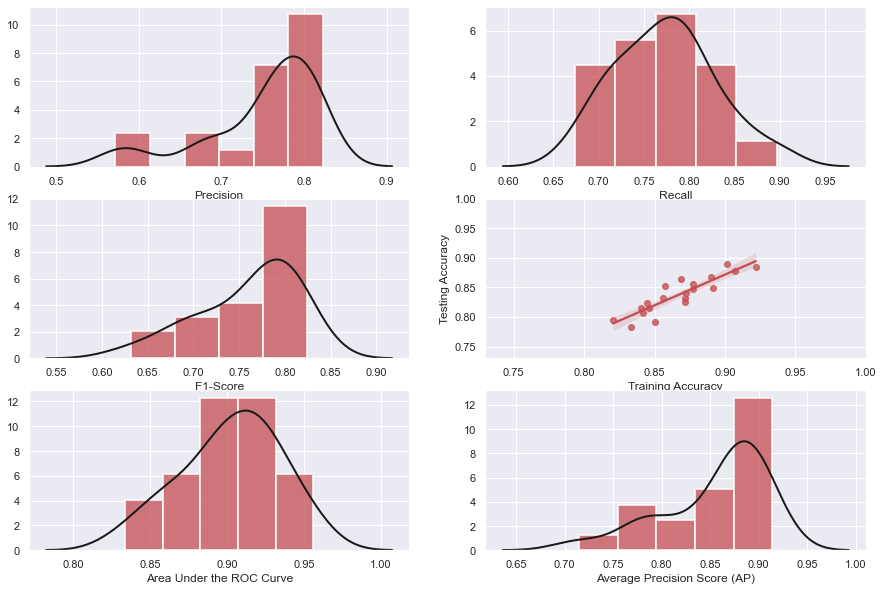

In [8]:
fig, axes = pp.subplots(figsize=(15, 10), nrows=3, ncols=2)
hist_kws = {'linewidth': 2, 'alpha': .75, 'color': 'r'}
kde_kws = {'color': 'k', 'lw': 2}
sns.distplot(results.precision, ax=axes[0, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 0].set_xlabel('Precision')
sns.distplot(results.recall, ax=axes[0, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[0, 1].set_xlabel('Recall')
sns.distplot(results.f1_score, ax=axes[1, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[1, 0].set_xlabel('F1-Score')
sns.regplot(x='train_accuracy', y='test_accuracy', data=results, ax=axes[1,1], color='r')
axes[1, 1].set_xlim([.73, 1])
axes[1, 1].set_ylim([.73, 1])
axes[1, 1].set_xlabel('Training Accuracy')
axes[1, 1].set_ylabel('Testing Accuracy')
sns.distplot(results.auc, ax=axes[2, 0], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 0].set_xlabel('Area Under the ROC Curve')
sns.distplot(results.ap, ax=axes[2, 1], hist_kws=hist_kws, kde_kws=kde_kws)
axes[2, 1].set_xlabel('Average Precision Score (AP)');

In [9]:
results.mean(axis=0)

train_size        10875.500000
test_size          2745.700000
precision             0.750291
recall                0.773470
f1_score              0.759965
auc                   0.902127
train_accuracy        0.867111
test_accuracy         0.837504
ap                    0.855096
dtype: float64

In [10]:
best_f1 = results[results.f1_score == results.f1_score.max()]
row_num = list(keys).index(best_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1694
           1       0.80      0.85      0.82       747

    accuracy                           0.89      2441
   macro avg       0.87      0.88      0.87      2441
weighted avg       0.89      0.89      0.89      2441



In [11]:
worst_f1 = results[results.f1_score == results.f1_score.min()]
row_num = list(keys).index(worst_f1.index.values[0])
print(report[row_num])

              precision    recall  f1-score   support

           0       0.87      0.82      0.85      2271
           1       0.60      0.67      0.63       870

    accuracy                           0.78      3141
   macro avg       0.73      0.75      0.74      3141
weighted avg       0.79      0.78      0.79      3141

